# Banking behavior cluster - Credit Card

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Task 
##### based on their banking behavior:
##### do they have savings account? How much do they save?
##### Do they have credit account? How much do they live in debt?
##### Are they making lot of small transactions or few huge ones?

## 1. Data Preparation and Feature Engineering

In [2]:
# import all data needed 

cre_acct = pd.read_csv('twm_credit_acct.csv', sep=';')
customer = pd.read_csv('twm_customer.csv', sep=';')
sv_acct = pd.read_csv('twm_savings_acct.csv', sep=';')
transaction = pd.read_csv('twm_transactions.csv', sep=';')

In [3]:
df_cre_acct = pd.DataFrame(cre_acct)
df_customer = pd.DataFrame(customer)
df_sv_acct = pd.DataFrame(sv_acct)
df_trans = pd.DataFrame(transaction)

#### sv acct 

In [4]:
df_sv_acct['change_in_savings'] = df_sv_acct['ending_balance'] - df_sv_acct['starting_balance']

# filter out inactive saving accounts
active_filter = df_sv_acct['account_active'] == 'Y '

# build bank behaviour df for each customer with savings acct
bank_bhv_sv = df_sv_acct[active_filter][['cust_id','acct_nbr','change_in_savings']]

bank_bhv_sv.isna().sum()


cust_id              0
acct_nbr             0
change_in_savings    0
dtype: int64

#### credit acct

In [5]:
df_cre_acct['change_in_debts'] = df_cre_acct['ending_balance'] - df_cre_acct['starting_balance']

# filter out inactive credit accounts
active_filter = df_cre_acct['account_active'] == 'Y '

# build bank behaviour df for each customer with credit acct
bank_bhv_cre = df_cre_acct[active_filter][['cust_id','acct_nbr', 'credit_limit', 'credit_rating', 'change_in_debts']]

bank_bhv_cre.isna().sum()

cust_id            0
acct_nbr           0
credit_limit       0
credit_rating      0
change_in_debts    0
dtype: int64

#### Banking behavior based on two accts

In [6]:
# join credit accts into customer listing with savings accts
bank_bhv = bank_bhv_cre.merge(bank_bhv_sv, left_on='cust_id', right_on='cust_id', how='left')

# if customers only have 1/2 accounts, fill NaN with 0
bank_bhv = bank_bhv.fillna(0)


In [7]:
# rename account number for different accounts
bank_bhv = bank_bhv.rename(columns={'acct_nbr_y':'savings_acct_nbr',
                         'acct_nbr_x':'credit_acct_nbr'})

In [8]:
# sv & cc acct data cleaned & merged
bank_bhv

,cust_id,credit_acct_nbr,credit_limit,credit_rating,change_in_debts,savings_acct_nbr,change_in_savings
0,1363160,4561143213631600,1000,0,-370.77,13631603.0,9.50
1,1362487,4561143213624870,3000,0,1548.23,0.0,0.00
2,1362548,4561143213625480,6700,0,-6896.57,13625483.0,3.78
3,1363017,4561143213630170,1000,0,1000.00,0.0,0.00
4,1362609,4561143213626090,3000,0,1224.93,13626093.0,-709.02
...,...,...,...,...,...,...,...
418,1362895,4561143213628950,1300,0,1300.00,13628953.0,-73.71
419,1363467,4561143213634670,1500,0,306.11,0.0,0.00
420,1363263,4561143213632630,3000,0,1218.94,0.0,0.00
421,1362569,4561143213625690,9200,0,9200.00,0.0,0.00


#### Customer data

In [9]:

# add customer data that maybe helpful to banking behavior (listed below in the columns)
bank_bhv = bank_bhv.merge(df_customer[['cust_id', 'income', 'years_with_bank']], 
                          left_on='cust_id', right_on='cust_id', how='left')

In [10]:
# df merged for credit acct + sv acct + customer(income, yr with bank)
bank_bhv

,cust_id,credit_acct_nbr,credit_limit,credit_rating,change_in_debts,savings_acct_nbr,change_in_savings,income,years_with_bank
0,1363160,4561143213631600,1000,0,-370.77,13631603.0,9.50,18548,8
1,1362487,4561143213624870,3000,0,1548.23,0.0,0.00,6605,1
2,1362548,4561143213625480,6700,0,-6896.57,13625483.0,3.78,44554,9
3,1363017,4561143213630170,1000,0,1000.00,0.0,0.00,0,1
4,1362609,4561143213626090,3000,0,1224.93,13626093.0,-709.02,1929,8
...,...,...,...,...,...,...,...,...,...
418,1362895,4561143213628950,1300,0,1300.00,13628953.0,-73.71,26387,6
419,1363467,4561143213634670,1500,0,306.11,0.0,0.00,29521,4
420,1363263,4561143213632630,3000,0,1218.94,0.0,0.00,13269,0
421,1362569,4561143213625690,9200,0,9200.00,0.0,0.00,61300,0


#### Transaction data

In [11]:
df_trans.head()

,tran_id,acct_nbr,tran_amt,principal_amt,interest_amt,new_balance,tran_date,tran_time,channel,tran_code
0,27,13625623,0.00,0.00,0.0,3753.34,21.10.1995,121656,A,IQ
1,97,13628392,0.00,0.00,0.0,254.49,5.2.1995,153053,V,IQ
2,21,13630842,-97.57,-97.57,0.0,3819.56,23.7.1995,0,P,WD
3,44,13631412,-0.15,-0.15,0.0,224.05,30.1.1995,0,,FK
4,31,13625722,0.00,0.00,0.0,240.55,25.1.1995,204521,B,IQ


In [12]:
# transaction data for each acct_nbr (can be either sv or credit) 
df_trans.groupby('acct_nbr').value_counts()

# 1. count(tran_id) as transaction times 
# 2. avg (tran_amt) as mean trans_amt per customer
# 3. ?? tran_time wtf is this 
# 4. sum (tran_amt) as total money spent per customer

acct_nbr          tran_id  tran_amt  principal_amt  interest_amt  new_balance  tran_date   tran_time  channel  tran_code
13624802          1        -297.38   -297.38        0.00           34.47       2.1.1995    0          P        WD           1
                  2        -0.15     -0.15          0.00           34.32       2.1.1995    0                   FK           1
                  57       -20.00    -20.00         0.00           28.86       21.1.1995   134752     A        WD           1
                  55       -112.87   -112.87        0.00           49.01       21.1.1995   0          P        WD           1
                  54       -161.89   -161.89        0.00           161.88      20.1.1995   191749     K        TR           1
                                                                                                                           ..
4561143213634920  17       -635.58   -635.58        0.00          -7100.00     13.5.1995   154408     E        CG          

In [13]:
# create new columns before processing data
df_trans['trans_count'] = df_trans['tran_id']
df_trans['avg_trans_amt'] = df_trans['tran_amt']
df_trans['sum_trans_amt'] = df_trans['tran_amt']

In [14]:
df_trans = df_trans[
    ['acct_nbr', 
    'trans_count', 
    'avg_trans_amt',
    'sum_trans_amt'
    ]].groupby('acct_nbr').agg(
    {'trans_count':'count',
    'sum_trans_amt':'sum',
    'avg_trans_amt':'mean'
    })

In [15]:
df_trans

,trans_count,sum_trans_amt,avg_trans_amt
acct_nbr,,,
13624802,99,-244.99,-2.474646
13624803,26,482.32,18.550769
13624842,99,-2518.14,-25.435758
13624843,33,1929.66,58.474545
13624852,99,-164.29,-1.659495
...,...,...,...
4561143213634830,77,25.78,0.334805
4561143213634840,39,471.14,12.080513
4561143213634850,23,3202.51,139.239565


In [16]:
# inner merge with banking behavior with acct_nbr to get each customer's transaction's data
# add saving acct
bank_bhv = bank_bhv.merge(df_trans, left_on='savings_acct_nbr', right_on='acct_nbr', how='inner')


In [17]:
bank_bhv.head()

# need to renmae x,y to distinguish btw credit and savings 

,cust_id,credit_acct_nbr,credit_limit,credit_rating,change_in_debts,savings_acct_nbr,change_in_savings,income,years_with_bank,trans_count,sum_trans_amt,avg_trans_amt
0,1363160,4561143213631600,1000,0,-370.77,13631603.0,9.50,18548,8,48,9.50,0.197917
1,1362548,4561143213625480,6700,0,-6896.57,13625483.0,3.78,44554,9,12,3.78,0.315000
2,1362609,4561143213626090,3000,0,1224.93,13626093.0,-709.02,1929,8,31,-708.48,-22.854194
3,1363078,4561143213630780,3000,0,-1238.14,13630783.0,468.57,9622,6,26,469.38,18.053077
4,1363200,4561143213632000,1100,3,254.56,13632003.0,1242.76,21015,3,31,1242.76,40.089032


In [18]:
# change name to not confuse with credit acct
bank_bhv = bank_bhv.rename(columns={
    'avg_trans_amt':'sav_trans_avg',
    'sum_trans_amt':'sav_trans_sum',
    'trans_count':'sav_trans_count'})

In [19]:
# add credit acct 
bank_bhv = bank_bhv.merge(df_trans, left_on='credit_acct_nbr', right_on='acct_nbr', how='inner')

In [20]:
bank_bhv = bank_bhv.rename(columns={
    'avg_trans_amt':'cre_trans_avg',
    'sum_trans_amt':'cre_trans_sum',
    'trans_count':'cre_trans_count'})

In [21]:
bank_bhv.head()

,cust_id,credit_acct_nbr,credit_limit,credit_rating,change_in_debts,savings_acct_nbr,change_in_savings,income,years_with_bank,sav_trans_count,sav_trans_sum,sav_trans_avg,cre_trans_count,cre_trans_sum,cre_trans_avg
0,1363160,4561143213631600,1000,0,-370.77,13631603.0,9.50,18548,8,48,9.50,0.197917,68,380.03,5.588676
1,1362548,4561143213625480,6700,0,-6896.57,13625483.0,3.78,44554,9,12,3.78,0.315000,22,6977.25,317.147727
2,1362609,4561143213626090,3000,0,1224.93,13626093.0,-709.02,1929,8,31,-708.48,-22.854194,44,-874.30,-19.870455
3,1363078,4561143213630780,3000,0,-1238.14,13630783.0,468.57,9622,6,26,469.38,18.053077,50,1314.07,26.281400
4,1363200,4561143213632000,1100,3,254.56,13632003.0,1242.76,21015,3,31,1242.76,40.089032,47,-238.84,-5.081702


In [22]:
bank_bhv.isna().sum()

cust_id              0
credit_acct_nbr      0
credit_limit         0
credit_rating        0
change_in_debts      0
savings_acct_nbr     0
change_in_savings    0
income               0
years_with_bank      0
sav_trans_count      0
sav_trans_sum        0
sav_trans_avg        0
cre_trans_count      0
cre_trans_sum        0
cre_trans_avg        0
dtype: int64

In [23]:
# need to drop nomial data (like ids & acc_nbr)
bank_bhv.drop(columns=['cust_id', 'credit_acct_nbr', 'savings_acct_nbr'], inplace=True)

In [24]:
# try
# bank_bhv.drop(columns=['credit_limit', 'credit_rating'], inplace=True)
# try 
# bank_bhv.drop(columns=['years_with_bank'], inplace=True)
# try
bank_bhv.drop(columns=['credit_rating'], inplace=True)

## 2. Dimensionality reduction 

### PCA -> 2D

In [25]:
bank_bhv.shape
# 15 features for banking behavior analysis

(235, 11)

In [26]:
x = bank_bhv

from sklearn.preprocessing import StandardScaler
# PCA use standardscaler as normalization is important in PCA since it is a variance maximizing exercise

sc = StandardScaler()
x_std = sc.fit_transform(x)

In [27]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_std)
x_pca.shape

(235, 2)

In [28]:
#PCA 2D plot
# """axis-label name"""
x_lbl, y_lbl = 'PCA 1', 'PCA 2'

# """data at eact axis to plot"""
x_plot, y_plot = x_pca[:,0], x_pca[:,1]


fig = go.Figure(data=[go.Scatter(x=x_plot, y=y_plot, mode='markers', 
                marker=dict(size=8,opacity=0.5))])
fig.update_layout(xaxis_title=x_lbl, yaxis_title=y_lbl,
    yaxis = dict(scaleanchor = "x",scaleratio = 1) )
fig.show()

In [29]:
# # try 
# pca = PCA(n_components=3)
# x_pca = pca.fit_transform(x_std)

# #PCA 3D plot
# x_lbl, y_lbl, z_lbl = 'PCA 1', 'PCA 2', 'PCA 3'

# x, y, z = x_pca[:,0], x_pca[:,1], x_pca[:,2]

# fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,mode='markers', marker=dict(size=8,opacity=0.5), name="data" )])
# fig.update_layout( xaxis_title=x_lbl, yaxis_title=y_lbl, yaxis = dict(scaleanchor = "x",scaleratio = 1) )
# fig.show()

## 3. Kmeans clustering

#### Elbow testing

In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(bank_bhv)

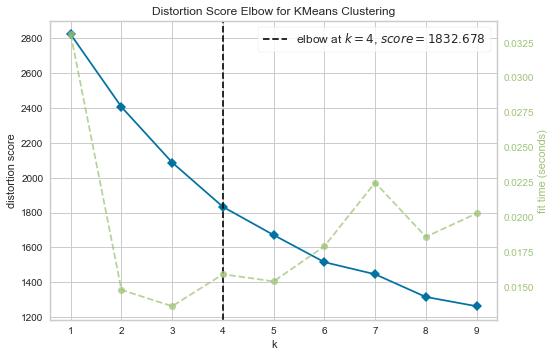

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(scaled_df)    
visualizer.poof()

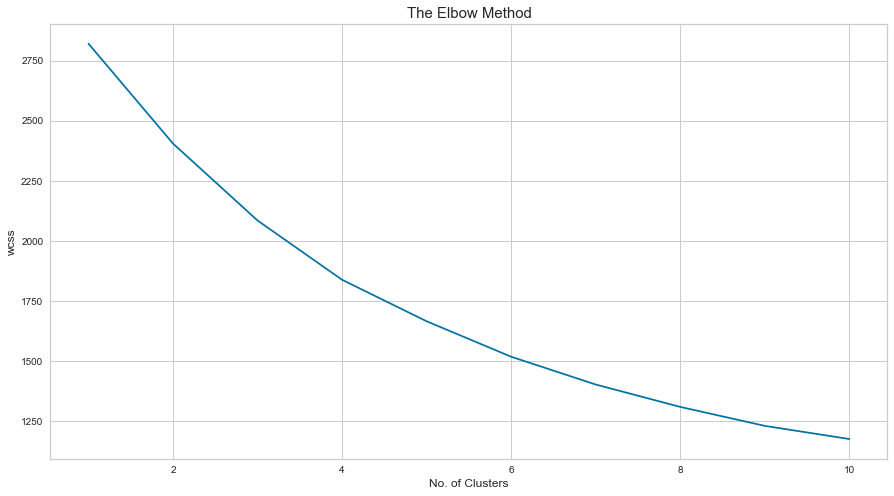

In [54]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(scaled_df)
    wcss.append(km.inertia_)

plt.figure(figsize=(15,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 15)
plt.xlabel('No. of Clusters', fontsize = 12)
plt.ylabel('wcss', fontsize = 12)
plt.show()  

In [55]:
# n_cluster = 4
km = KMeans(n_clusters=4)
y_km = km.fit_predict(scaled_df)

In [56]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster, 0]
        y = X[y_res == cluster, 1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.show()

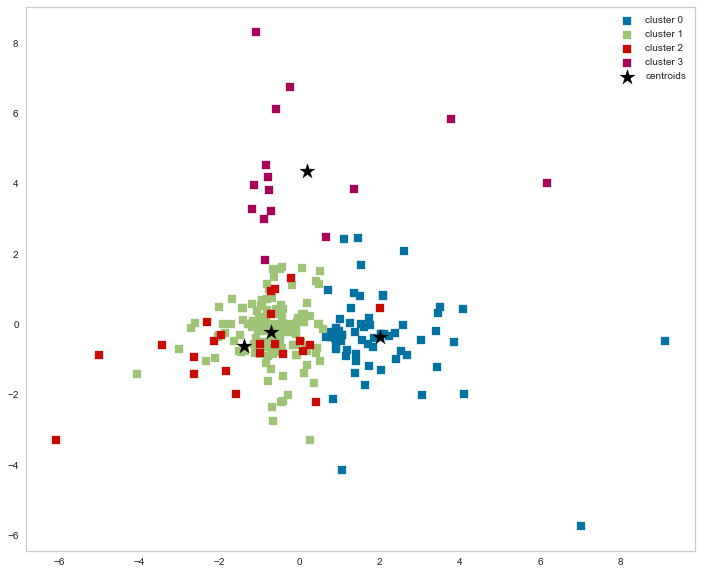

In [57]:
# customer demographics
from matplotlib.pyplot import figure
figure(figsize=(12, 10))
plt.grid(None)
plot_clusters(x_pca, y_km, plt_cluster_centers= True)


### Radar plot

In [58]:
bank_bhv['cluster'] = KMeans(n_clusters=4, n_init=10).fit_predict(bank_bhv)
bank_bhv['cluster'].value_counts()
df_radar = bank_bhv.groupby('cluster').mean().divide(bank_bhv.drop('cluster',axis=1).mean())
df_radar.head()

,credit_limit,change_in_debts,change_in_savings,income,years_with_bank,sav_trans_count,sav_trans_sum,sav_trans_avg,cre_trans_count,cre_trans_sum,cre_trans_avg
cluster,,,,,,,,,,,
0,0.669375,0.597794,1.029586,0.326231,0.980866,0.991354,1.029511,1.054968,0.998671,0.530292,0.993826
1,1.888738,1.195706,0.575833,2.141900,1.021246,1.004527,0.576240,0.700969,0.927116,0.933790,0.083033
2,0.876008,0.985331,1.029516,1.100103,0.979053,1.011061,1.029356,0.991268,1.041825,1.111932,1.532587
3,2.817533,6.480983,2.500361,4.355434,1.424476,0.987701,2.501146,1.850232,0.944700,7.544423,0.065097


In [59]:
import plotly.graph_objects as go


fig = go.Figure()

for i in df_radar.index:
  fig.add_trace(
                go.Scatterpolar(
                                r=df_radar.loc[i].values,
                                theta=df_radar.columns,
                                fill='toself',
                                name=f'Cluster {i} ',
                                )
                )
fig.update_layout(
    polar=dict(
        radialaxis=dict(
          visible=True,
        ),
      ),
    showlegend=True,
    title="Customer Banking Behavior Radar"
)

fig.show()

In [ ]:
# Cluster 0 : a large group of customers who have very-low income, small spenders (low purchase), lowest credit limit.
# Cluster 1 : a large group of customers who have medium income, medium spenders, second-high credit limit
# Cluster 2 : a small group of customers who have low income, medium spenders, third-high credit limit
# Cluster 3 : a small group of customers who have high income, low purchase frequency (low trans count), highest credit limit.
# We can assume that  customer cluster 3 uses their credit cards as a loan (high debts and high cre trans sum).